# Import librairies

In [1]:
import pandas as pd, numpy as np, seaborn as sns, warnings, os
from datetime import datetime as dt
from matplotlib import pyplot as plt

import matplotlib.font_manager as fm
import plotly.express as px
import plotly.graph_objs as go

font1 = fm.FontProperties(size=20)
font2 = fm.FontProperties(size=24)

warnings.filterwarnings(action="ignore")

if int(str(sns.__version__).split('.')[1]) > 8 : 
    plt.style.use('seaborn-v0_8-darkgrid')
else:
    plt.style.use('seaborn-darkgrid')
sns.set(font_scale=3)

In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Outils

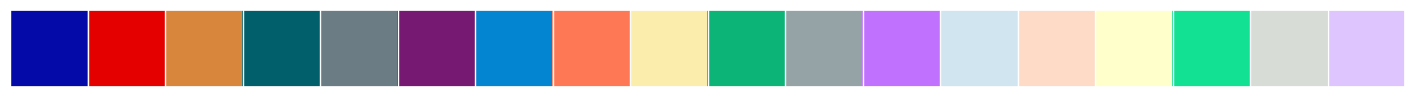

In [3]:
palette = [ "#030aa7", "#e50000", "#d8863b", "#005f6a", "#6b7c85", "#751973", 
            "#0485d1", "#ff7855", "#fbeeac", "#0cb577", "#95a3a6", "#c071fe", 
            "#d1e5f0", "#fddbc7", "#ffffcb", "#12e193", "#d8dcd6", "#dfc5fe", 
          ]
sns.palplot(sns.color_palette(palette))

In [4]:
repertoireRacine  = '.'
nomProjet         = 'AnalyseIris'

repertoireProjet  = os.path.join(repertoireRacine, nomProjet)
repertoireDonnees = os.path.join(repertoireProjet, 'repertoire.donnees')
repertoireImages  = os.path.join(repertoireProjet, 'repertoire.images')


def controleExistenceRepertoire( repertoire, create_if_needed=True):
    """Voir si le répertoire existe. S'il n'existe pas il est créé."""
    path_exists = os.path.exists(repertoire)
    if path_exists:
        if not os.path.isdir(repertoire):
            raise Exception("Trouvé le nom  "+repertoire +" mais c'est un fichier, pas un répertoire")
            # return False
        return True
    if create_if_needed:
        os.makedirs(repertoire)

def sauvegarderImage( fichier):
    """Enregistrez la figure. Appelez la méthode juste avant plt.show ()."""
    controleExistenceRepertoire(repertoireImages)
    plt.savefig(os.path.join(repertoireImages,
                             fichier+f"--{dt.now().strftime('%Y_%m_%d_%H.%M.%S')}.png"), 
                             dpi=600, 
                             bbox_inches='tight')

def sauvegarderImageSNS( sns_plot, fichier):
    """Enregistrez la figure. Appelez la méthode juste avant plt.show ()."""
    controleExistenceRepertoire(repertoireImages)
    fig = sns_plot.get_figure()
    fig.savefig(os.path.join(repertoireImages,fichier+'.png'))
    
controleExistenceRepertoire(repertoireProjet);
controleExistenceRepertoire(repertoireDonnees);
controleExistenceRepertoire(repertoireImages);

In [5]:
def afficheDendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Classification Hiérarchique Ascendante')
        plt.xlabel('Villes ou (taille du cluster)')
        plt.ylabel('Distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [6]:
donnees = pd.read_csv('../donnees/Iris.csv', index_col='Id')
donnees.Species = donnees.Species.apply(lambda x : x.replace('Iris-',''))
donnees.columns = [colonne.replace('Cm','') if colonne != 'Species' else colonne for colonne in donnees.columns]
donnees.head()

SepalLength  SepalWidth  PetalLength  PetalWidth Species
Id                                                          
1           5.1         3.5          1.4         0.2  setosa
2           4.9         3.0          1.4         0.2  setosa
3           4.7         3.2          1.3         0.2  setosa
4           4.6         3.1          1.5         0.2  setosa
5           5.0         3.6          1.4         0.2  setosa

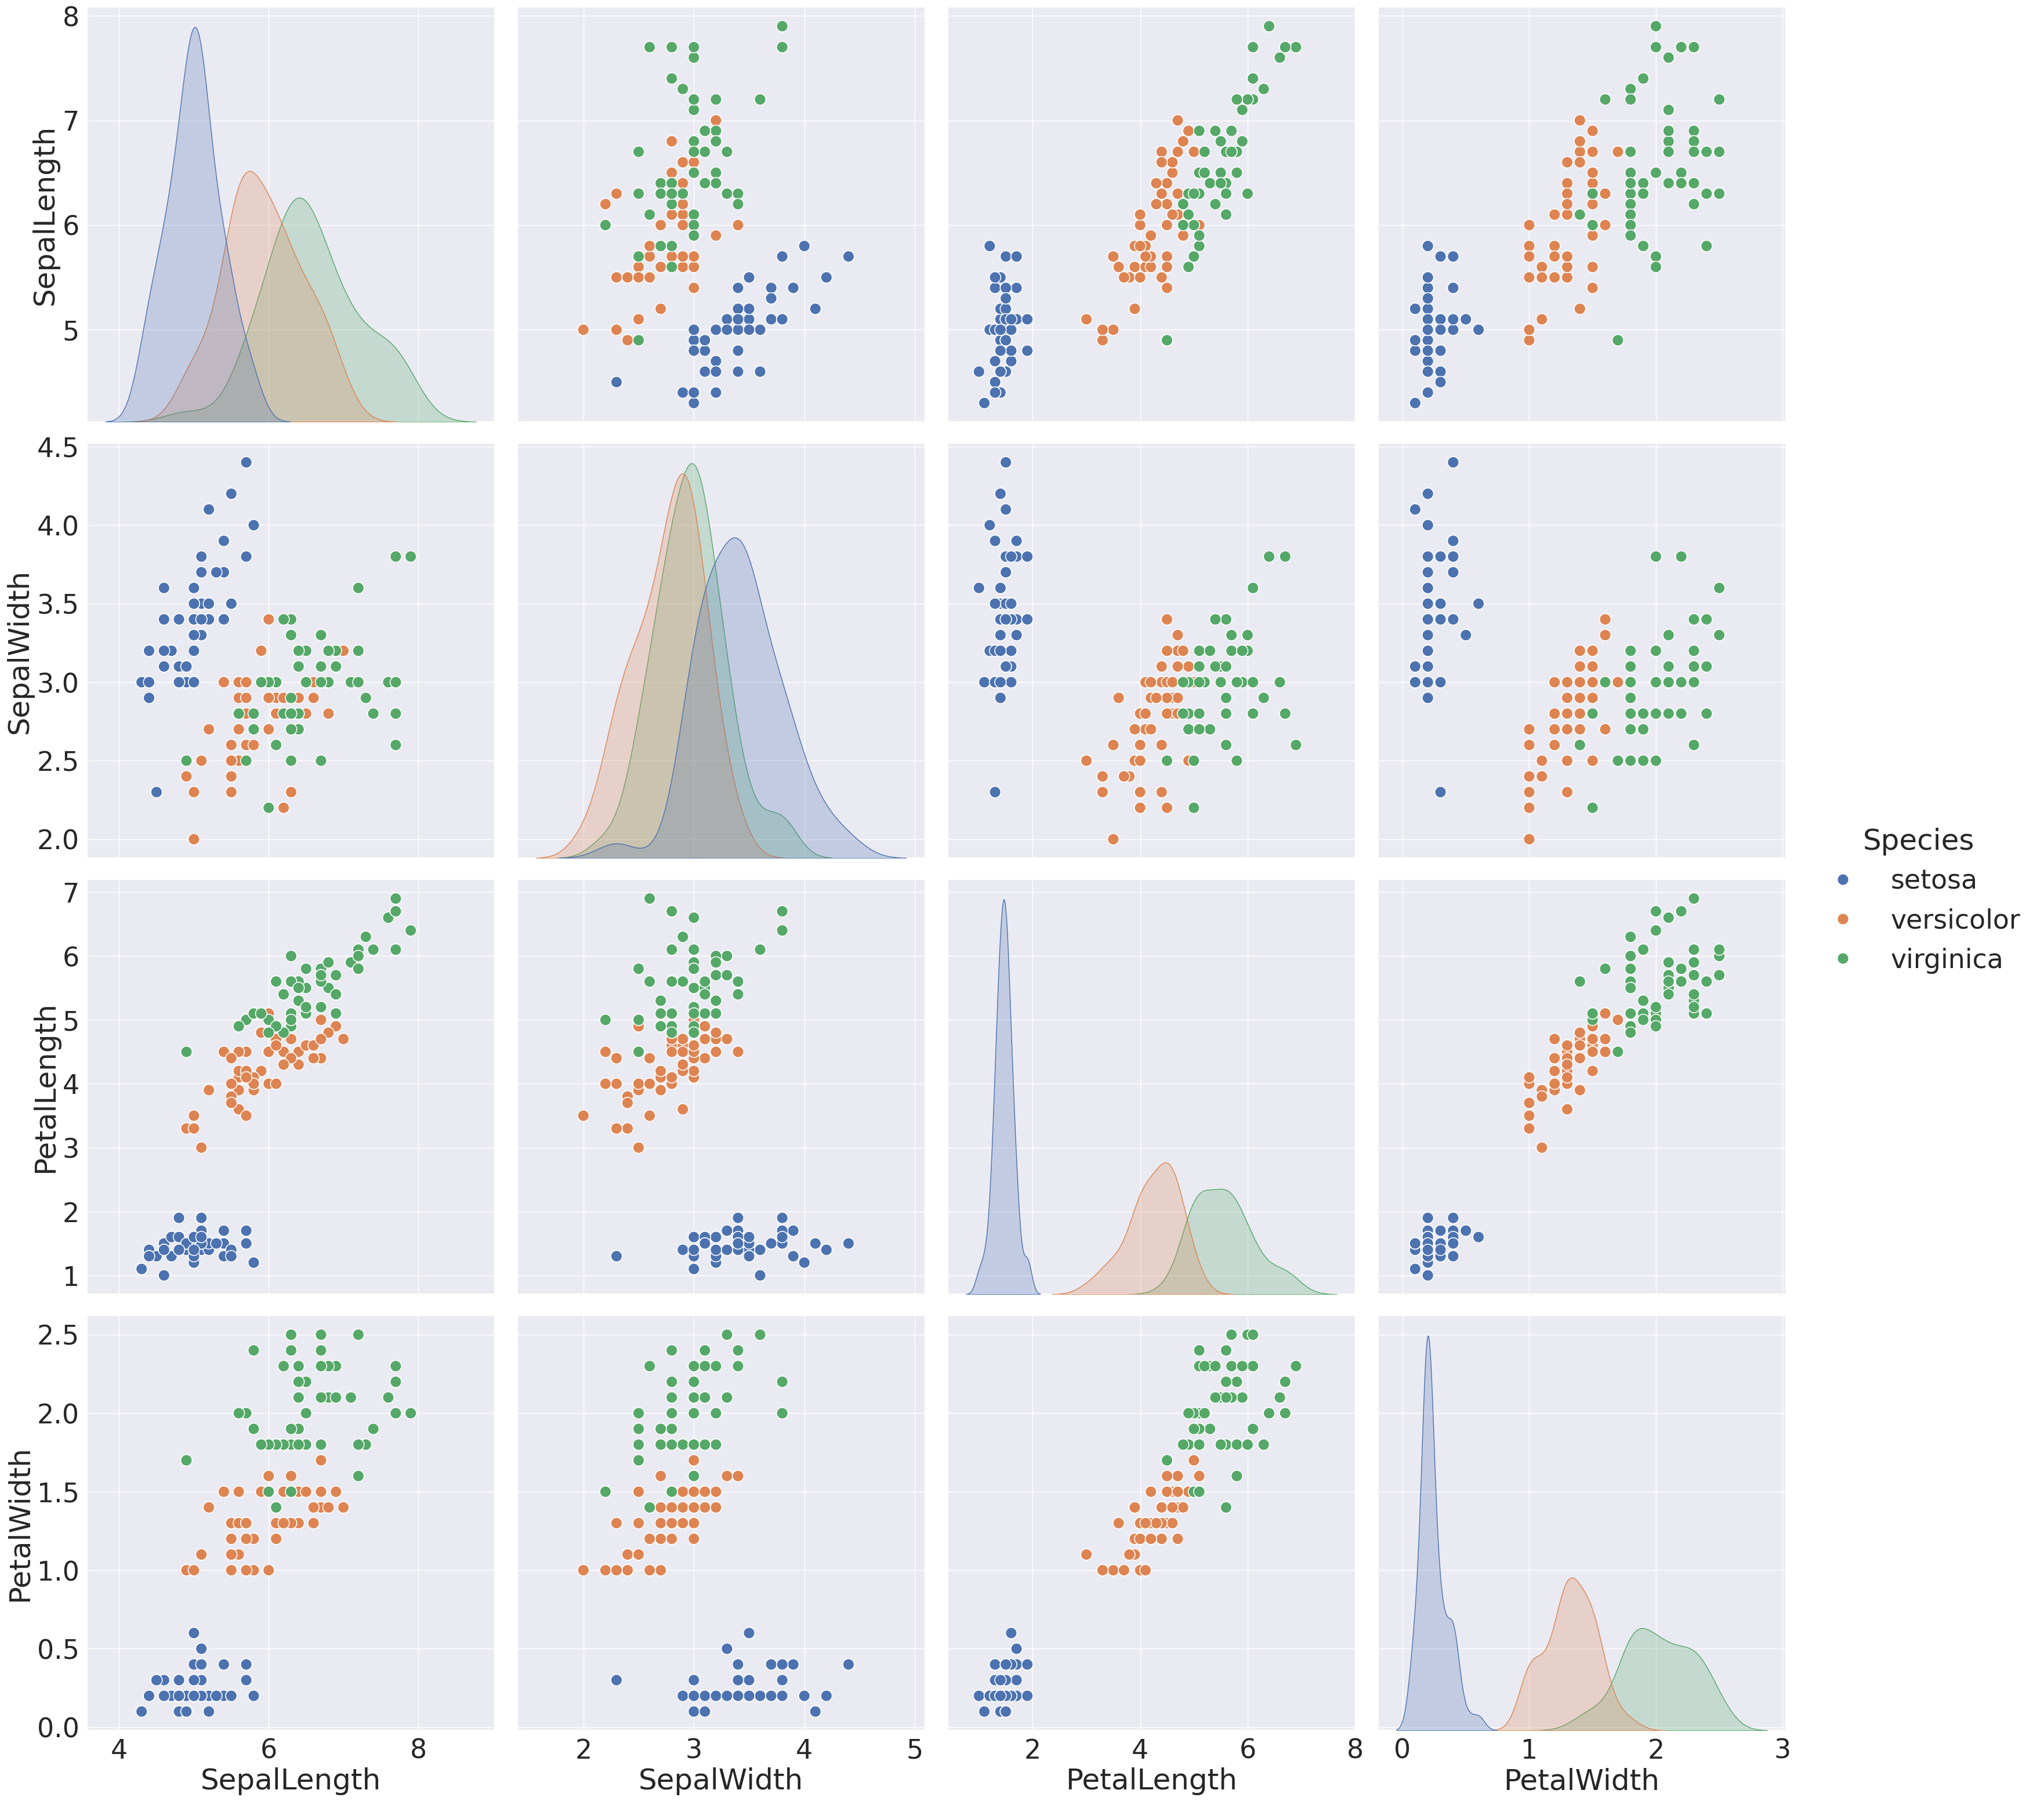

In [7]:
sns.pairplot(donnees, hue='Species', size=8, plot_kws={"s": 200});

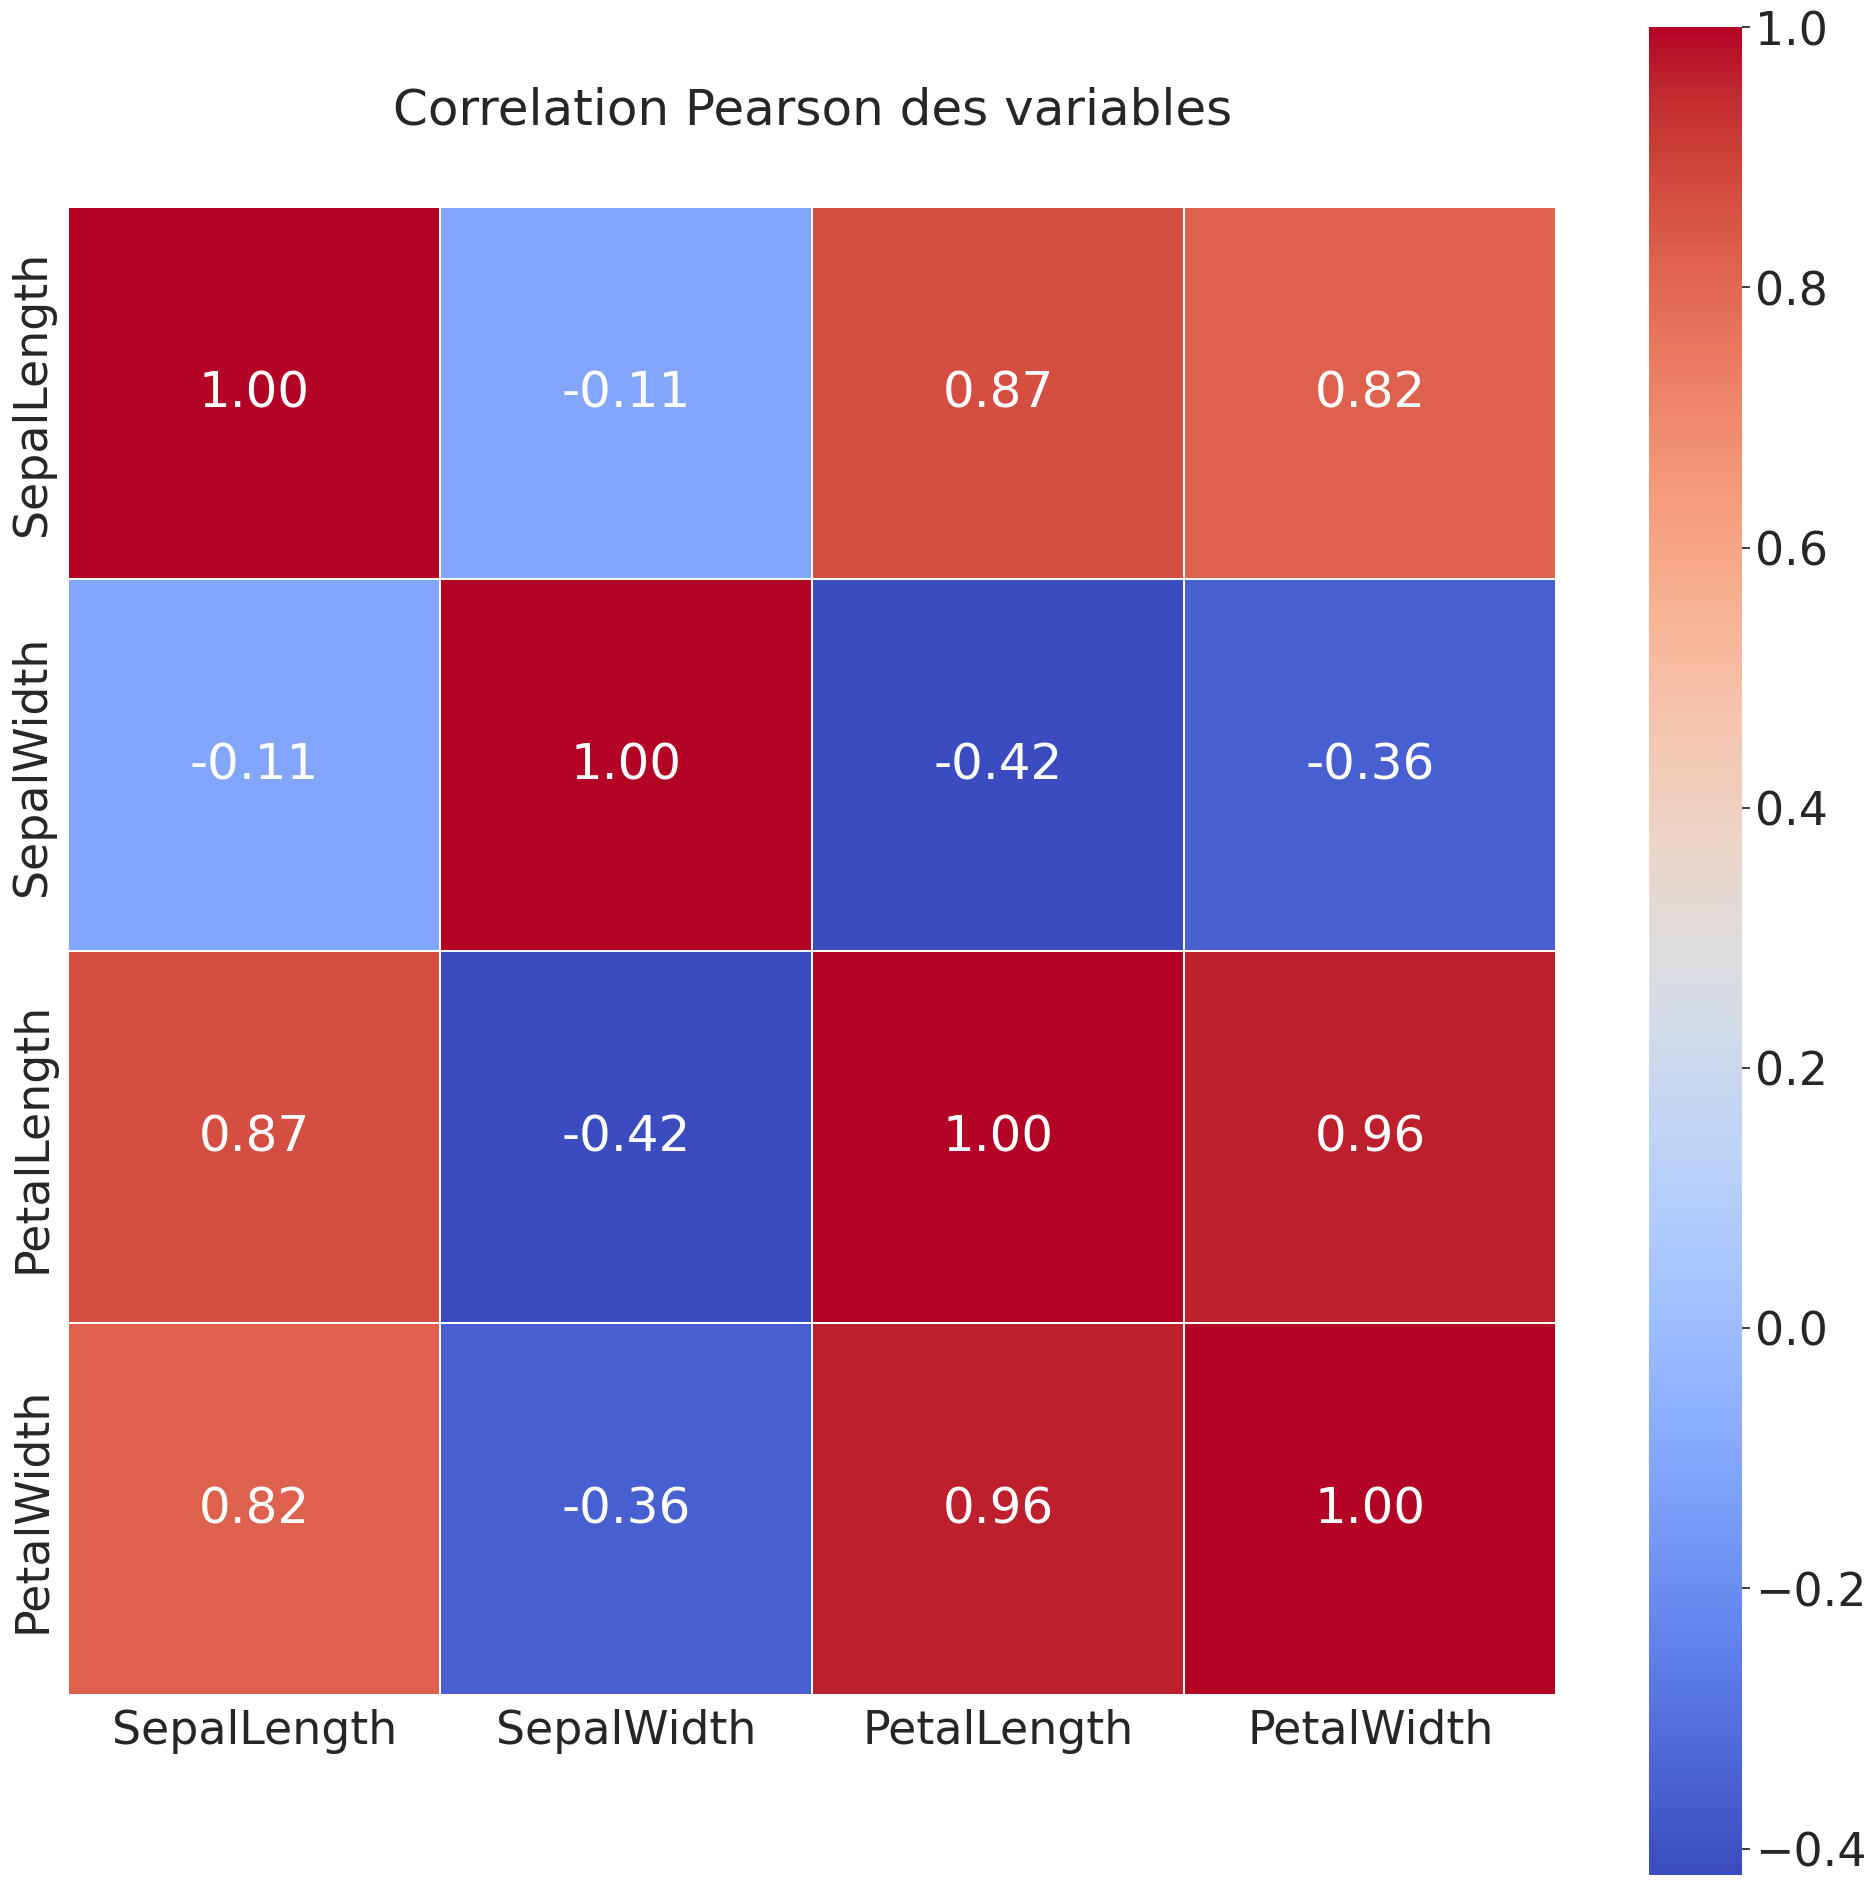

In [8]:
plt.figure(figsize=(24,24))
sns.set(font_scale=3)
plt.title('Correlation Pearson des variables', y=1.05, size=36)
sns.heatmap(donnees.set_index('Species').corr(),linewidths=0.3, fmt= '.2f', #vmax=1.0, 
            square=True, cmap='coolwarm', linecolor='white', annot=True)
# sauvegarderImage('Correlation Pearson des variables--DonneesM')
sns.set(font_scale=2)

# Classification hiérarchique ascendante

In [9]:
Species = donnees.Species.values
donnees.set_index('Species',inplace=True)
donnees.head()

SepalLength  SepalWidth  PetalLength  PetalWidth
Species                                                  
setosa           5.1         3.5          1.4         0.2
setosa           4.9         3.0          1.4         0.2
setosa           4.7         3.2          1.3         0.2
setosa           4.6         3.1          1.5         0.2
setosa           5.0         3.6          1.4         0.2

## Calcul des arbres 

In [10]:
Z = linkage(donnees, 'ward')

## Affichage des arbres *2 clases* par défaut 

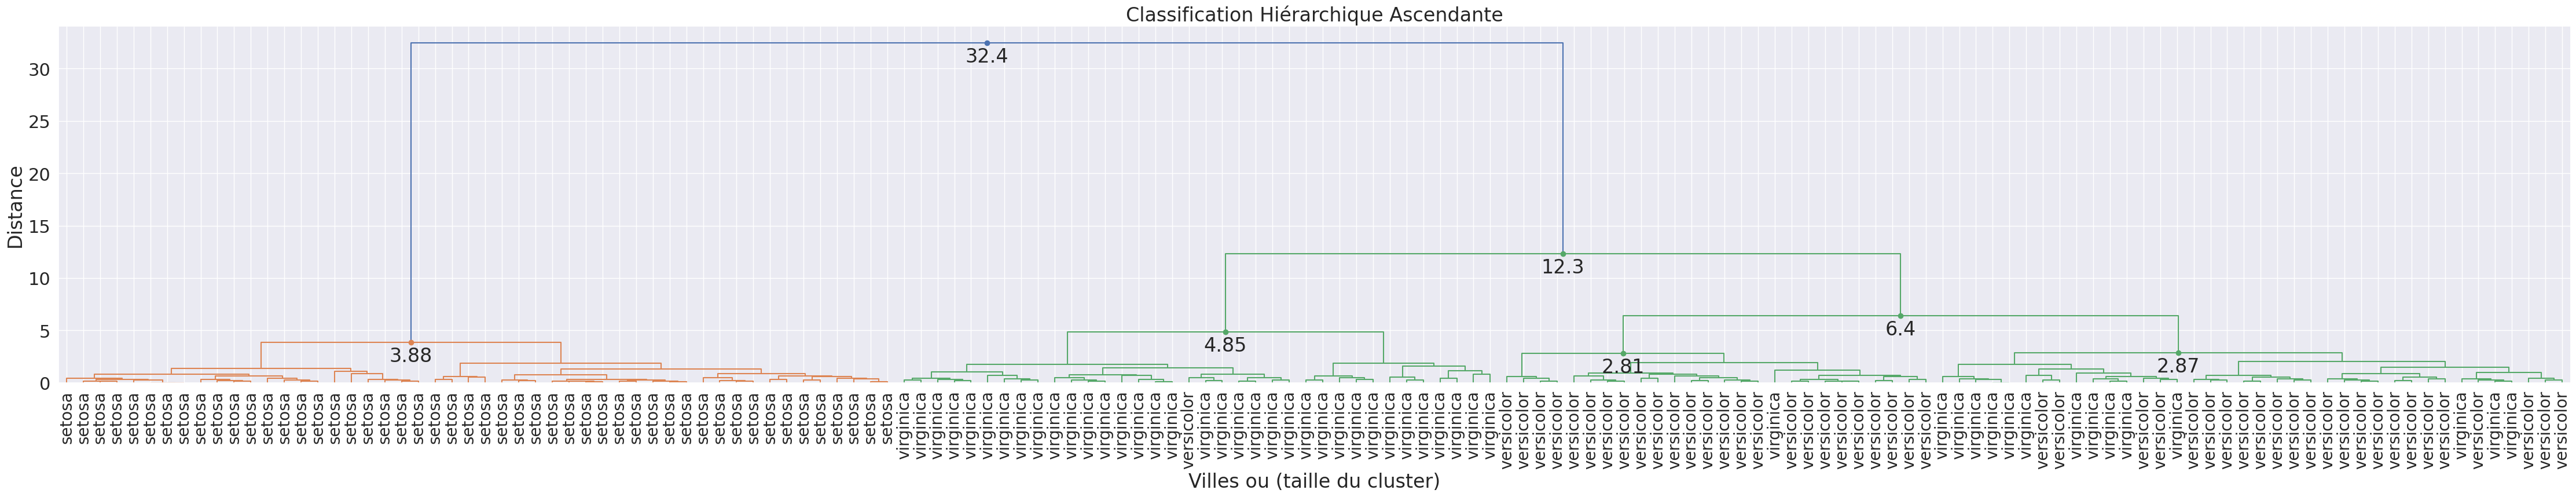

In [11]:
plt.figure(figsize=(56,8))
afficheDendrogram(
    Z,
    truncate_mode='lastp',
    p=150,                          # nombres des classes
    leaf_rotation=90.,
    leaf_font_size=20.,
    show_contracted=True,
    annotate_above=2.5,              # les annotations à partir de cette distance
    # max_d=75,                      # la distance de découpage de l’arbre
    labels = Species
)
plt.show()

## Affichage des arbres *3 clases*

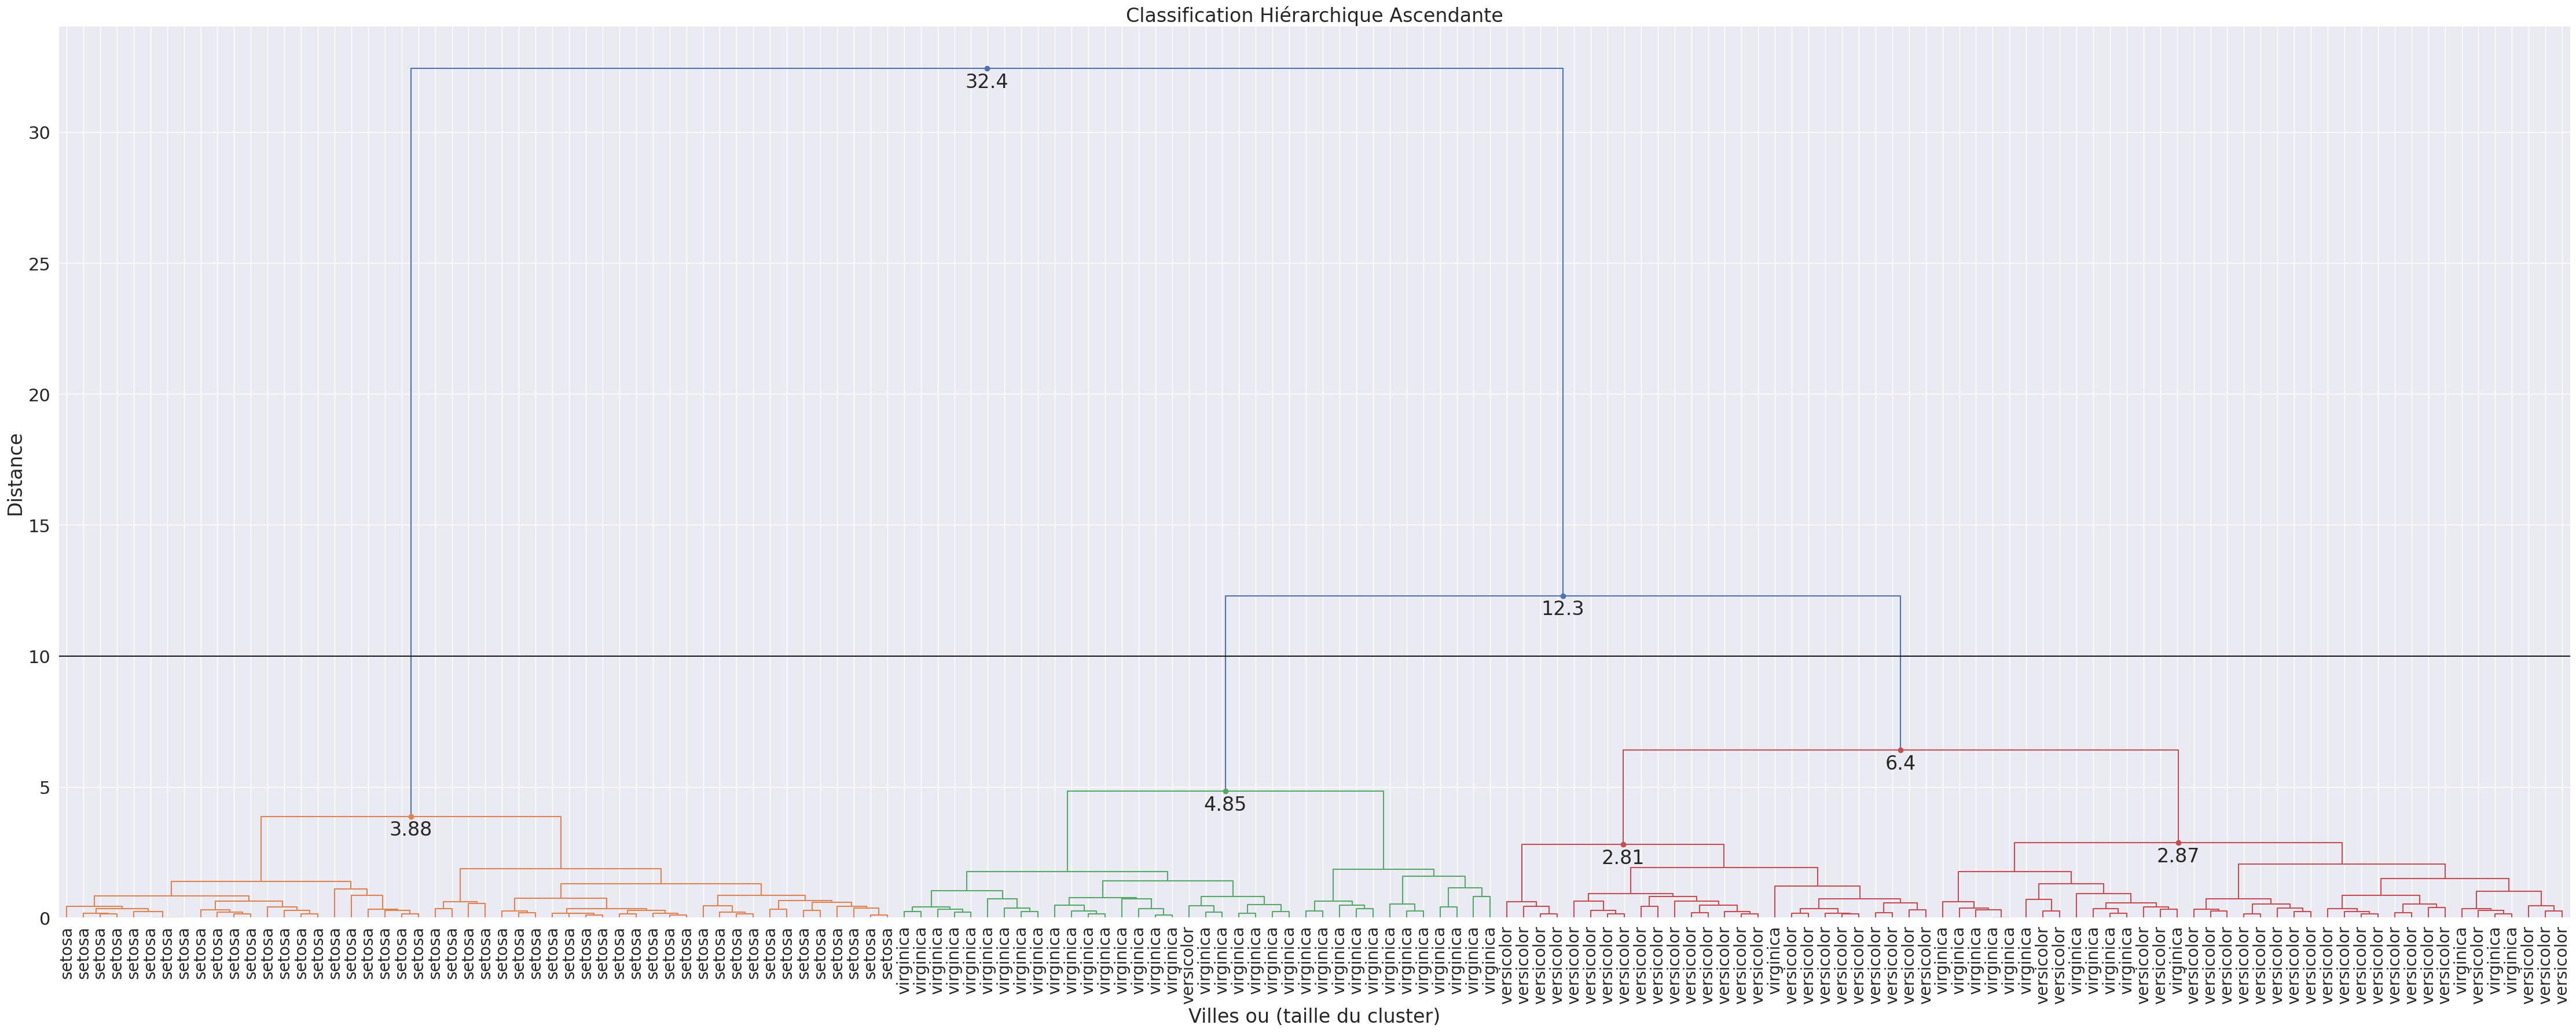

In [12]:
plt.figure(figsize=(56,20))
afficheDendrogram(
    Z,
    truncate_mode='lastp',
    p=150,                          # nombres des classes
    leaf_rotation=90.,
    leaf_font_size=20.,
    show_contracted=True,
    annotate_above=2.5,              # les annotations à partir de cette distance
    max_d=10,                      # la distance de découpage de l’arbre
    labels = Species
)
plt.show()

## Prédiction des classes

In [13]:
donnees['Classes2']=fcluster(Z, t=15, criterion='distance')
donnees['Classes3']=fcluster(Z, t=10, criterion='distance')

# KMeans

In [14]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(donnees.values)
y_kmeans = kmeans.predict(donnees.values)
donnees['KMeans2'] = y_kmeans+1
kmeans = KMeans(n_clusters=3)
kmeans.fit(donnees.values)
y_kmeans = kmeans.predict(donnees.values)
donnees['KMeans3'] = y_kmeans+1

In [15]:
donnees.reset_index(inplace=True)
donnees.head()

Species  SepalLength  SepalWidth  PetalLength  PetalWidth  Classes2  \
0  setosa          5.1         3.5          1.4         0.2         1   
1  setosa          4.9         3.0          1.4         0.2         1   
2  setosa          4.7         3.2          1.3         0.2         1   
3  setosa          4.6         3.1          1.5         0.2         1   
4  setosa          5.0         3.6          1.4         0.2         1   

   Classes3  KMeans2  KMeans3  
0         1        2        2  
1         1        2        2  
2         1        2        2  
3         1        2        2  
4         1        2        2

# Contrôle de la création des Clusters - Classification hiérarchique ascendante

In [16]:
fig = px.scatter( donnees, 
                  x='SepalLength', 
                  y='SepalWidth', 
                  color='Species',
                  size=donnees.Classes3,
                  symbol=donnees.Classes3,
                  text='Species',
                  width=1024,
                  height=1024,
                  )

fig.show()

In [17]:
donnees[donnees.Classes3 == 1].Species.unique()

array(['setosa'], dtype=object)

In [18]:
sum(donnees[donnees.Classes3 == 2].Species != 'virginica')

1

In [19]:
sum(donnees[donnees.Classes3 == 3].Species != 'versicolor')

15

In [20]:
(1 - (16 / 150))*100

89.33333333333333

<img src="https://raw.githubusercontent.com/rbizoi/IntelligenceEnDonneesDeSante/refs/heads/main/images/silhouette.png" width="512">

In [21]:
silhouette_score(donnees.set_index('Species'),donnees.Classes2)

0.6738902324719235

In [22]:
silhouette_score(donnees.set_index('Species'),donnees.Classes3)

0.718346122704934

# Contrôle de la création des Clusters - Classification KMeans

In [23]:
fig = px.scatter( donnees, 
                  x='SepalLength', 
                  y='SepalWidth', 
                  color='Species',
                  size=donnees.KMeans3,
                  symbol=donnees.KMeans3,
                  text='Species',
                  width=1024,
                  height=1024,
                  )

fig.show()

In [24]:
donnees[donnees.KMeans3 == 1].Species.unique(),donnees[donnees.KMeans3 == 2].Species.unique(),donnees[donnees.KMeans3 == 3].Species.unique()

(array(['versicolor', 'virginica'], dtype=object),
 array(['setosa'], dtype=object),
 array(['versicolor', 'virginica'], dtype=object))

In [25]:
sum(donnees[donnees.KMeans3 == 1].Species != 'versicolor')

15

In [26]:
donnees[donnees.KMeans3 == 2].Species.unique()

array(['setosa'], dtype=object)

In [27]:
sum(donnees[donnees.KMeans3 == 3].Species != 'virginica')

1

In [28]:
(1 - (16 / 150))*100

89.33333333333333

<img src="https://raw.githubusercontent.com/rbizoi/IntelligenceEnDonneesDeSante/refs/heads/main/images/silhouette.png" width="512">

In [29]:
silhouette_score(donnees.set_index('Species'),donnees.KMeans2)

0.6738902324719235

In [30]:
silhouette_score(donnees.set_index('Species'),donnees.KMeans3)

0.718346122704934